This notebook is mainly for messing around with Geopandas objects and figuring out what the best way is to plan a path\
To run this code, you need to install shapely, geopandas matplotlib and numpy 

In [1]:
import json
import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from shapely.geometry import LineString,MultiLineString
import geopandas as gpd
import numpy as np

In [2]:
# This cell opens the json file that contains field geometry
with open("./data/field_geometry/test_1.json") as json_file:
    json_data = json.load(json_file) # or geojson.load(json_file)

In [3]:
# This cell parses the json data and obtains a list with the coordinates for each polygon like
# [[polygon1_coords],[polygon2_coords],....]
# where polygon1_coords looks something like this: [[x1,y1],[x2,y2],......]
coordinates = []
for i in range(len(json_data['features'])):
    coordinates.append(json_data['features'][i]['geometry']['coordinates'])

<Axes: >

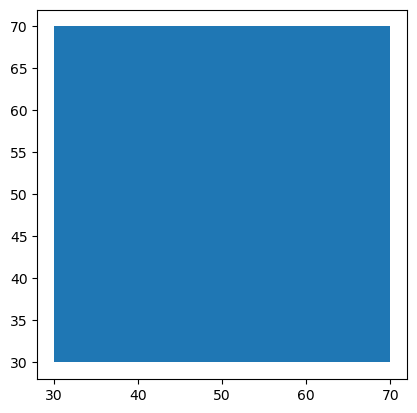

In [4]:
# Here we create a geoseries object from the polygons 
polygon1 = gpd.GeoSeries(Polygon(coordinates[1][0]))
hole = gpd.GeoSeries(Polygon(coordinates[2][0]))
# Creating a buffer with a specific size (in this case 1)
obstacle_buffer = hole.buffer(1)
polygon1_buffer = polygon1.buffer(-1)
hole.plot()

In [5]:
# Here we substract the hole from the field, the first line does this for the field and hole without headlands, the second line does it
# for field and hole with headlands

field = polygon1.symmetric_difference(hole)

field_with_headlands = polygon1_buffer.symmetric_difference(obstacle_buffer)

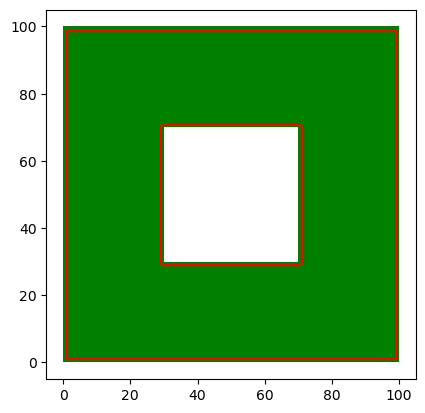

In [6]:
# Plotting the field (green) and headland boundaries
fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
plt.show()

In [7]:
# An easy way to obtain x and y coordinates for a polygon or polyline
polygon1.get_coordinates()

,x,y
0,0.0,0.0
0,0.0,100.0
0,100.0,100.0
0,100.0,0.0
0,0.0,0.0


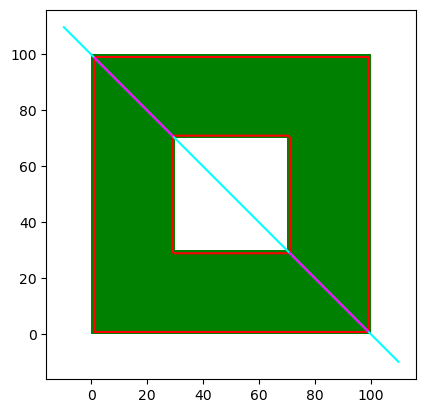

In [8]:
# Creating straight lines as vectors and clipping them to the field boundaries
vector = [[-10,110],[110,-10]]
# Here we make another geoseries object from the vector
swath = gpd.GeoSeries(LineString(vector))
# and we clip the vector so that it only covers the field and does not cross over into the headlands
swath_clipped = gpd.clip(swath,field_with_headlands)


# Plotting the original swath (cyan) and the clipped one (magenta)

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
swath.plot(ax = ax,color = 'cyan', marker = '+')
swath_clipped.plot(ax = ax, color = 'magenta')
plt.show()

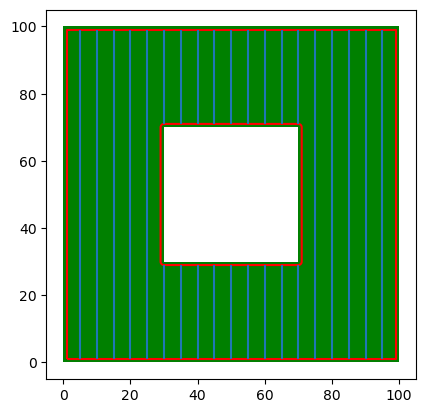

1484.0


In [9]:

# This cell combines the above cells and creates a bunch of parallel vectors with a fixed distance, clips them to the 
# boundaries of the field and then calculates the total length of the path

vector = []
for i in range(100):
    vector.append([[0+i*5,100],[0+i*5,0]])

swaths = []
swaths_clipped = []
for i in range(len(vector)):
    swaths.append(gpd.GeoSeries(LineString(vector[i])))
    swaths_clipped.append(gpd.clip(swaths[i],field_with_headlands))

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
total_swath_length = 0
for i in range(len(swaths_clipped)):
    if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length for vectors that are completely outside of the boundaries
        swaths_clipped[i].plot(ax = ax)
        total_swath_length+=swaths_clipped[i][0].length

plt.show()
print(total_swath_length)

In [10]:
# import numpy as np

def rotate_vector_z(vector, theta_z):
    # Convert angle to radians
    theta_z = np.radians(theta_z)

    # 2D Rotation matrix around the z-axis
    R_z = np.array([[np.cos(theta_z), -np.sin(theta_z)],
                    [np.sin(theta_z), np.cos(theta_z)]])

    # Rotate the vector
    rotated_vector = np.dot(R_z, vector)

    return rotated_vector

# Example usage
vector = np.array([1, 0])  # Example vector along the x-axis
theta_z = 45  # Rotation angle in degrees around z-axis

rotated_vector = rotate_vector_z(vector, theta_z)
print("Original Vector:", vector)
print("Rotated Vector around Z-axis:",rotated_vector)

Original Vector: [1 0]
Rotated Vector around Z-axis: [0.70710678 0.70710678]


In [11]:
# Example usage
vector = np.array([10000, 0])  # Example vector along the x-axis
for theta_z in range(0,95,5):
    # theta_z = 45  # Rotation angle in degrees around z-axis
    d = 10
    dx = d/(np.sin(np.radians(theta_z))+0.01)
    rotated_vector = rotate_vector_z(vector, theta_z)
    rotated_vector = [[0,0],list(rotated_vector)]
    vector_list = []
    if theta_z == 0:
        for i in range(-10,10):
            vector_list.append([[rotated_vector[0][0],rotated_vector[0][1]+i*d],[rotated_vector[1][0],rotated_vector[1][1]+i*d]])
    else:
        for i in range(-10,10):
            vector_list.append([[rotated_vector[0][0]+i*dx,rotated_vector[0][1]],[rotated_vector[1][0]+dx*i,rotated_vector[1][1]]])



    swaths = []
    swaths_clipped = []
    for i in range(len(vector_list)):
        swaths.append(gpd.GeoSeries(LineString(vector_list[i])))
        swaths_clipped.append(gpd.clip(swaths[i],field_with_headlands))

    # fig, ax = plt.subplots()
    # field.plot(ax = ax, color = 'green')
    # field_with_headlands.boundary.plot(ax = ax,color = 'red')
    total_swath_length = 0
    for i in range(len(swaths_clipped)):
        if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length for vectors that are completely outside of the boundaries
            # swaths_clipped[i].plot(ax = ax)
            total_swath_length+=swaths_clipped[i][0].length

    # plt.show()
    
    print('Theta: {:6f}, total_length: {:6f}'.format(theta_z,total_swath_length))



Theta: 0.000000, total_length: 672.000000
Theta: 5.000000, total_length: 860.948812
Theta: 10.000000, total_length: 831.740609
Theta: 15.000000, total_length: 816.633977
Theta: 20.000000, total_length: 813.056012
Theta: 25.000000, total_length: 804.817470
Theta: 30.000000, total_length: 800.732728
Theta: 35.000000, total_length: 798.668438
Theta: 40.000000, total_length: 797.552416
Theta: 45.000000, total_length: 796.682440
Theta: 50.000000, total_length: 795.625354
Theta: 55.000000, total_length: 794.563742
Theta: 60.000000, total_length: 794.564152
Theta: 65.000000, total_length: 793.030607
Theta: 70.000000, total_length: 797.975278
Theta: 75.000000, total_length: 798.882329
Theta: 80.000000, total_length: 794.944562
Theta: 85.000000, total_length: 804.631815
Theta: 90.000000, total_length: 672.090946


Theta: 5.000000, total_length: 860.948812


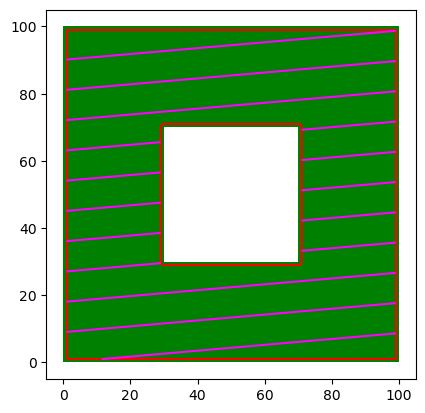

In [12]:
d = 10
theta_z = 5  # Rotation angle in degrees around z-axis
dx = d/(np.sin(np.radians(theta_z))+0.01)
# dx = d
vector = np.array([10000, 0])
rotated_vector = rotate_vector_z(vector, theta_z)
rotated_vector = [[0,0],list(rotated_vector)]
vector_list = []
if theta_z == 0:
    for i in range(-10,10):
        vector_list.append([[rotated_vector[0][0],rotated_vector[0][1]+i*d],[rotated_vector[1][0],rotated_vector[1][1]+i*d]])
else:
    for i in range(-10,10):
        vector_list.append([[rotated_vector[0][0]+i*dx,rotated_vector[0][1]],[rotated_vector[1][0]+dx*i,rotated_vector[1][1]]])



swaths = []
swaths_clipped = []
for i in range(len(vector_list)):
    swaths.append(gpd.GeoSeries(LineString(vector_list[i])))
    swaths_clipped.append(gpd.clip(swaths[i],field_with_headlands))

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
total_swath_length = 0
for i in range(len(swaths_clipped)):
    if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length 
        #for vectors that are completely outside of the boundaries
        swaths_clipped[i].plot(ax = ax,color = 'magenta')
        total_swath_length+=swaths_clipped[i][0].length
print('Theta: {:6f}, total_length: {:6f}'.format(theta_z,total_swath_length))

plt.show()

Theta: 10.000000, total_length: 649.949715


,x,y


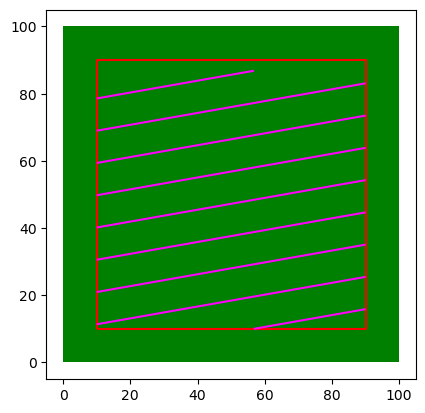

In [13]:
field1 = gpd.GeoSeries(Polygon(coordinates[1][0]))
field1_with_headlands = field1.buffer(-10)
fig, ax = plt.subplots()
field1.plot(ax = ax, color = 'green')
field1_with_headlands.boundary.plot(ax = ax, color = 'red')


d = 10
theta_z = 10  # Rotation angle in degrees around z-axis
dx = d/(np.sin(np.radians(theta_z))+0.01)
# dx = d
vector = np.array([500, 0])
rotated_vector = rotate_vector_z(vector, theta_z)
rotated_vector = [[0,0],list(rotated_vector)]
vector_list = []
if theta_z == 0:
    for i in range(-10,10):
        vector_list.append([[rotated_vector[0][0],rotated_vector[0][1]+i*d],[rotated_vector[1][0],rotated_vector[1][1]+i*d]])
else:
    for i in range(-10,10):
        vector_list.append([[rotated_vector[0][0]+i*dx,rotated_vector[0][1]],[rotated_vector[1][0]+dx*i,rotated_vector[1][1]]])

swaths = []
swaths_clipped = []
for i in range(len(vector_list)):
    swaths.append(gpd.GeoSeries(LineString(vector_list[i])))
    swaths_clipped.append(gpd.clip(swaths[i],field1_with_headlands))

total_swath_length = 0
for i in range(len(swaths_clipped)):
    if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length 
        #for vectors that are completely outside of the boundaries
        swaths_clipped[i].plot(ax = ax,color = 'magenta')
        total_swath_length+=swaths_clipped[i][0].length
print('Theta: {:6f}, total_length: {:6f}'.format(theta_z,total_swath_length))


swaths_clipped[15].get_coordinates()

In [14]:

swaths_clipped_nonempty = [swath for swath in swaths_clipped if not swath.get_coordinates().empty]
list_coords = []
for i in range(len(swaths_clipped_nonempty)):
    list_coords.append(swaths_clipped_nonempty[0].get_coordinates())


In [15]:
from dubins_curves import *

line1 = swaths_clipped_nonempty[0]
line2 = swaths_clipped_nonempty[1]
line1_coords = line1.get_coordinates()
line2_coords = line2.get_coordinates()
point1 = line1_coords.iloc[1]
point2 = line2_coords.iloc[1]



diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
slope1 = diff1['y']/diff1['x']
heading_1 = math.degrees(math.atan(slope1))

diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
slope2 = diff2['y']/diff1['x']
heading_2 = math.degrees(math.atan(slope2))+180

pt1 = (line1_coords.iloc[1]['x'],line1_coords.iloc[1]['y'],90-heading_1)
pt2 = (line2_coords.iloc[1]['x'],line2_coords.iloc[1]['y'],90-heading_2)
turning_rad = 5

path = dubins_main(pt1,pt2,turning_rad)




In [16]:
heading_2

196.77746956185308

In [17]:
# LineString(path)
curve1 = LineString(path[:,0:2])

<Axes: >

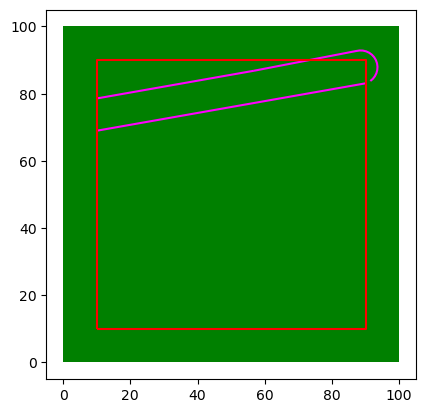

In [18]:
# MultiLineString((line1,curve1,line2))
line = gpd.GeoSeries((line1[0],curve1,line2[0]))
fig, ax = plt.subplots()
line.plot(ax = ax, color = 'magenta')
field1.plot(ax = ax, color = 'green')
field1_with_headlands.boundary.plot(ax = ax, color = 'red')
# line1[0]

In [26]:

turning_rad = 5
line = []

for i in range(len(swaths_clipped_nonempty)-1):
    line1 = swaths_clipped_nonempty[i]
    line2 = swaths_clipped_nonempty[i+1]
    line1_coords = line1.get_coordinates()
    line2_coords = line2.get_coordinates()

    if i%2 != 0:
        point1 = line1_coords.iloc[0]
        point2 = line2_coords.iloc[0]
        diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
        slope1 = diff1['y']/diff1['x']
        heading_1 = math.degrees(math.atan(slope1))+180

        diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
        slope2 = diff2['y']/diff1['x']
        heading_2 = math.degrees(math.atan(slope2))
        pt1 = (line1_coords.iloc[0]['x'],line1_coords.iloc[0]['y'],90-heading_1)
        pt2 = (line2_coords.iloc[0]['x'],line2_coords.iloc[0]['y'],90-heading_2)
    else:
        print('hoi')
        point1 = line1_coords.iloc[1]
        point2 = line2_coords.iloc[1]
        print(point1)
        diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
        slope1 = diff1['y']/diff1['x']
        heading_1 = math.degrees(math.atan(slope1))

        diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
        slope2 = diff2['y']/diff1['x']
        heading_2 = math.degrees(math.atan(slope2))+180
        pt1 = (line1_coords.iloc[1]['x'],line1_coords.iloc[1]['y'],90-heading_1)
        pt2 = (line2_coords.iloc[1]['x'],line2_coords.iloc[1]['y'],90-heading_2)



    path = dubins_main(pt1,pt2,turning_rad)
    curve1 = LineString(path[:,0:2])
    line.append(gpd.GeoSeries((line1[0],curve1,line2[0])))
        


hoi
x    56.788337
y    86.824089
Name: 0, dtype: float64
hoi
x    90.000000
y    73.477508
Name: 0, dtype: float64
hoi
x    90.000000
y    54.274815
Name: 0, dtype: float64
hoi
x    90.000000
y    35.072121
Name: 0, dtype: float64


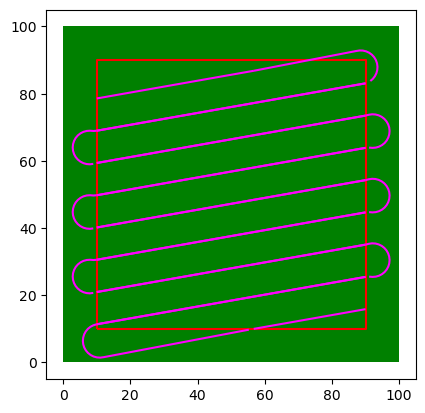

In [27]:

fig, ax = plt.subplots()

field1.plot(ax = ax, color = 'green')
field1_with_headlands.boundary.plot(ax = ax, color = 'red')
for i in range(len(line)):
    line[i].plot(ax = ax, color = 'magenta')

In [21]:
line1_coords.iloc[1]

x    90.000000
y    25.470775
Name: 0, dtype: float64